In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import fuzzy
import fuzzy.storage.fcl.Reader
from fuzzy.doc.plot.gnuplot import doc

# Import Fuzzy Output System

In [13]:
system = fuzzy.storage.fcl.Reader.Reader().load_from_file("FIS/lab5-1.fcl")

# Several function for convenient further work

## Periodic model of pressure

In [14]:
def periodic_model_of_pressure(time=0, dtime=0):
    '''
        @param time - 
        @param dtime - 
    '''
    
    p1 = 0.5 * ( 0.05 * np.sin(time) + 1 )
    p2 = 0.3 * ( 0.05 * np.sin(time + 10 * dtime) + 1 )
    
    return (p1, p2)

## AR model of pressure

In [15]:
def ar_model_of_pressure(prev_p1=0, prev_p2=0, mu=0, sigma_1=1, sigma_2=1):
    '''
        @param prev_p1
        @param prev_p2
        
        @param mu
        @param sigma
    '''
    
    eps_1 = np.random.normal(loc=mu, scale=sigma_1, size=1)
    eps_2 = np.random.normal(loc=mu, scale=sigma_2, size=1)
    
    p1 = 0.5 + 0.07 * prev_p1 + eps_1
    p2 = 0.3 - 0.05 * prev_p2 + eps_2
    
    return (p1, p2)

# Main part

In [16]:
def prepaire_input(pressure=0, input_valve=0):
    
    sys_input = {
        'pressure': pressure,
        'input_valve': input_valve
    }
    
    return sys_input

In [17]:
def prepaire_output():
    sys_output = {
        'output_valve': 0, 
    }
    
    return sys_output

# Calculations

## Periodic flucatuations

In [18]:
def calc_ro(P, z = 0.96, R = 500, T = 300):
    return P / (z * R * T)

def calc_M(gamma, square, eps, p_in, p_out, ro):
    return gamma * square * np.sqrt(2 / eps * ro * (p_in - p_out))

def calc_tau(V = 100, z = 0.96, R = 500, T = 300):
    return V / (z * R * T)

def calc_a(M1, M2, tau, p_s, p_0):
    return (M1 - M2) / (tau * (p_s - p_0))

def calc_ps(P1, P2, gamma2):
    P = P1 - P2 * gamma2 ** 2 + np.sqrt((P2 * gamma2 ** 2 - P1) ** 2 + 4 * (P2 ** 2) * (gamma2 ** 2))
    return P / 2

def calc_p(P0, Ps, a, delta_t):
    return (P0 - Ps) * np.exp(-a * delta_t) + Ps

In [81]:
time = 25000
dtime = 50

S1 = S2 = 0.3
eps1 = eps2 = 0.3
z = 0.96
R = 500
T = 300
V = 100
P_const = 0.45

gamma2 = 0.5
gamma1 = 1
tau = calc_tau()

In [20]:
(P1, P2) = periodic_model_of_pressure(time=0, dtime=dtime)
P0 = calc_ps(P1, P2, gamma2)

P_list = [P0]
gamma = [gamma2]

In [21]:
for i in np.arange(dtime, time, dtime):

    (P1, P2) = periodic_model_of_pressure(time=i, dtime=dtime)
    
    input_ = prepaire_input(pressure=(P0 - P_const) / P_const, input_valve=gamma2)
    output = prepaire_output()
    
    new_delta_valve = system.calculate(input_, output)['output_valve']

    gamma2 += new_delta_valve
    gamma.append(gamma2)
    
    ro1 = calc_ro(P0)
    ro2 = calc_ro(P2)
    
    M1 = calc_M(gamma1, S1, eps1, P1, P0, ro1)
    M2 = calc_M(gamma2, S2, eps2, P0, P2, ro2)
    
    Ps = calc_ps(P1, P2, gamma2)
    a = calc_a(M1, M2, tau, Ps, P0)
    P = calc_p(P0, Ps, a, i)  
    
    P0 = P
    P_list.append(P0)

### P plot

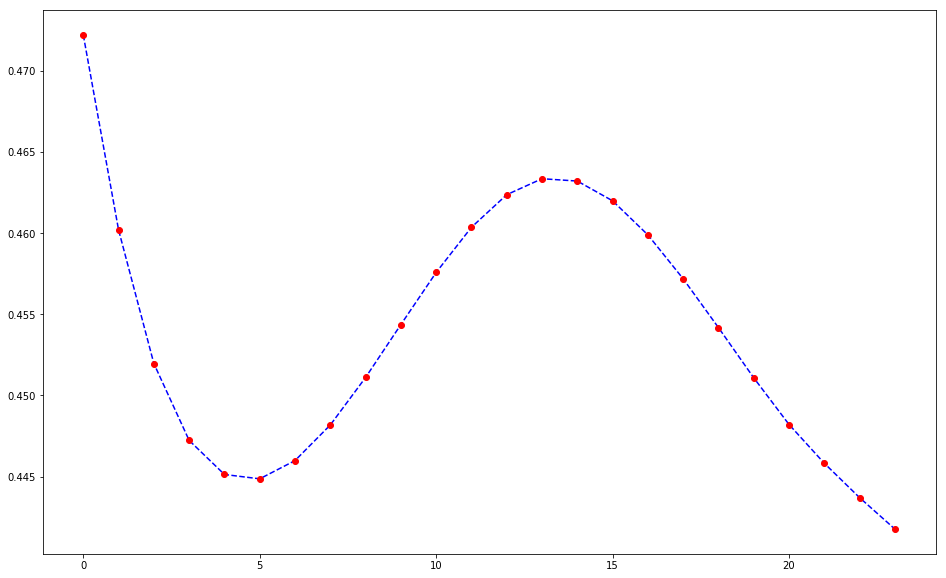

In [22]:
plt.figure(figsize=(16, 10))
plt.plot(P_list, '--b')
plt.plot(P_list, 'or')

plt.show()

### Gamma plot

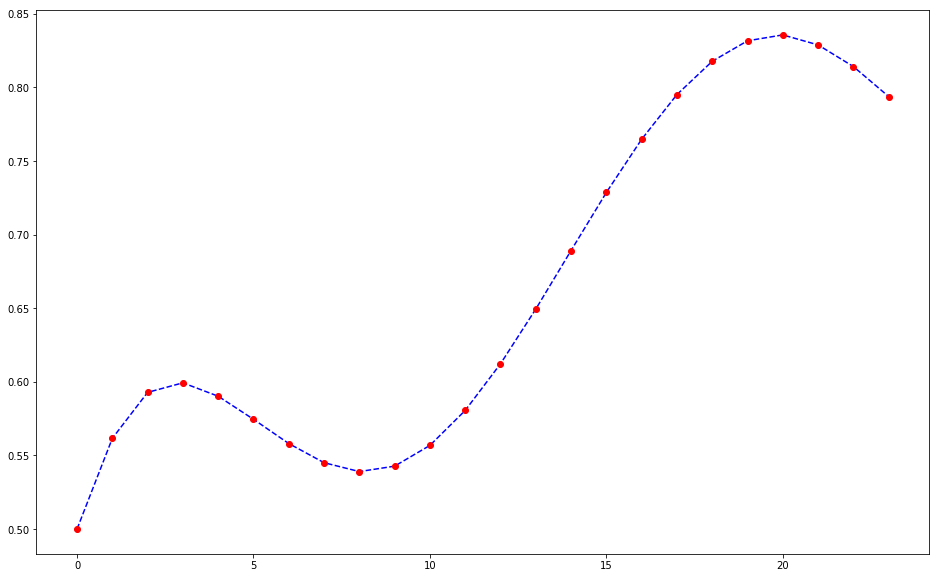

In [23]:
plt.figure(figsize=(16, 10))
plt.plot(gamma, '--b')
plt.plot(gamma, 'or')


plt.show()

## AR fluctuations

In [24]:
gamma2 = 0.5

(P1, P2) = (0.5, 0.3)
P0 = calc_ps(P1, P2, gamma2)

P_list = [P0]
gamma = [gamma2]

In [25]:
for i in np.arange(dtime, time, dtime):

    
    (P1, P2) = ar_model_of_pressure(prev_p1=P1, prev_p2=P2, sigma_1=0.01, sigma_2=0.012)
    
    input_ = prepaire_input(pressure=(P0 - P_const) / P_const, input_valve=gamma2)
    output = prepaire_output()
    
    new_delta_valve = system.calculate(input_, output)['output_valve']

    gamma2 += new_delta_valve
    gamma.append(gamma2)
    
    ro1 = calc_ro(P0)
    ro2 = calc_ro(P2)
    
    M1 = calc_M(gamma1, S1, eps1, P1, P0, ro1)
    M2 = calc_M(gamma2, S2, eps2, P0, P2, ro2)
    
    Ps = calc_ps(P1, P2, gamma2)
    a = calc_a(M1, M2, tau, Ps, P0)
    P = calc_p(P0, Ps, a, i)  
    
    P0 = P
    P_list.append(P0)

### P plot

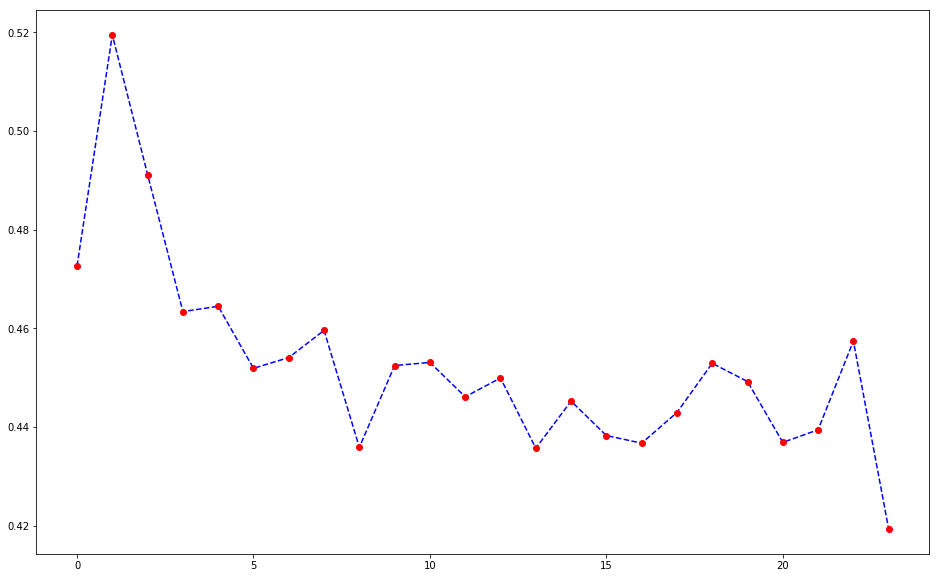

In [26]:
plt.figure(figsize=(16, 10))
plt.plot(P_list, '--b')
plt.plot(P_list, 'or')

plt.show()

### Gamma plot

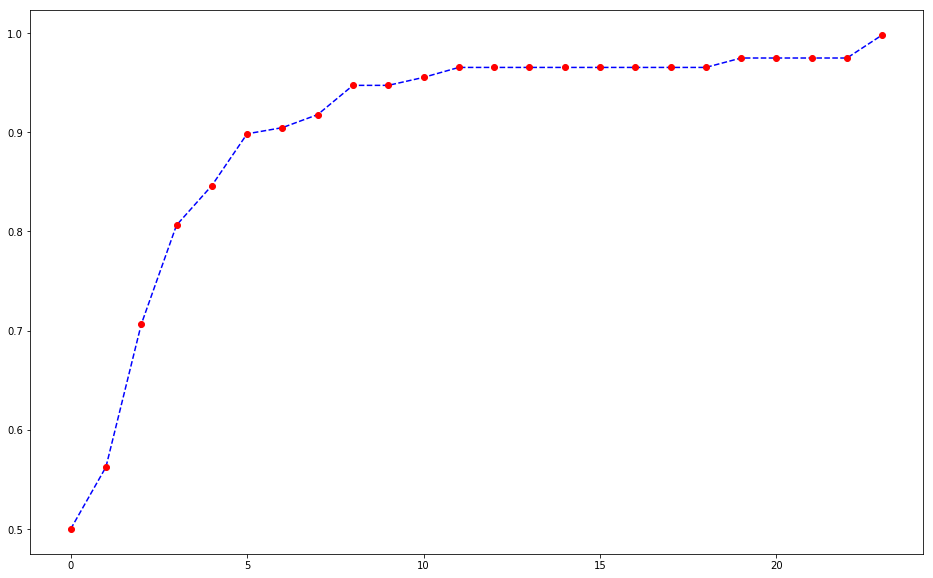

In [27]:
plt.figure(figsize=(16, 10))
plt.plot(gamma, '--b')
plt.plot(gamma, 'or')


plt.show()

# PID regulation

In [102]:
gamma2 = 0.5
P1, P2 = periodic_model_of_pressure(time=0, dtime=dtime)
P0 = calc_ps(P1, P2, gamma2)

P_list = [P0]
es = [(P0 - P_const) / P_const]

gamma = [gamma2]

In [103]:
def PID(K_p, K_i, K_d, DE, dtime):

    U = K_p * DE[-1] + K_i * dtime * sum(DE) + K_d * (DE[-1] - DE[-2]) / dtime
    
    return U

In [104]:
for i in np.arange(dtime, time, dtime):
    
    P1, P2 = periodic_model_of_pressure(time=i, dtime=dtime)
    
    es.append((P0 - P_const) / P_const)
    new_delta_valve = PID(2.1, 0.02, 0, es, dtime)
    
    gamma2 += new_delta_valve
    gamma.append(gamma2)
    
    ro1 = calc_ro(P0)
    ro2 = calc_ro(P2)
    
    M1 = calc_M(gamma1, S1, eps1, P1, P0, ro1)
    M2 = calc_M(gamma2, S2, eps2, P0, P2, ro2)
    
    Ps = calc_ps(P1, P2, gamma2)
    a = calc_a(M1, M2, tau, Ps, P0)
    P = calc_p(P0, Ps, a, i)
        
    P0 = P
    P_list.append(P0)

### P plot

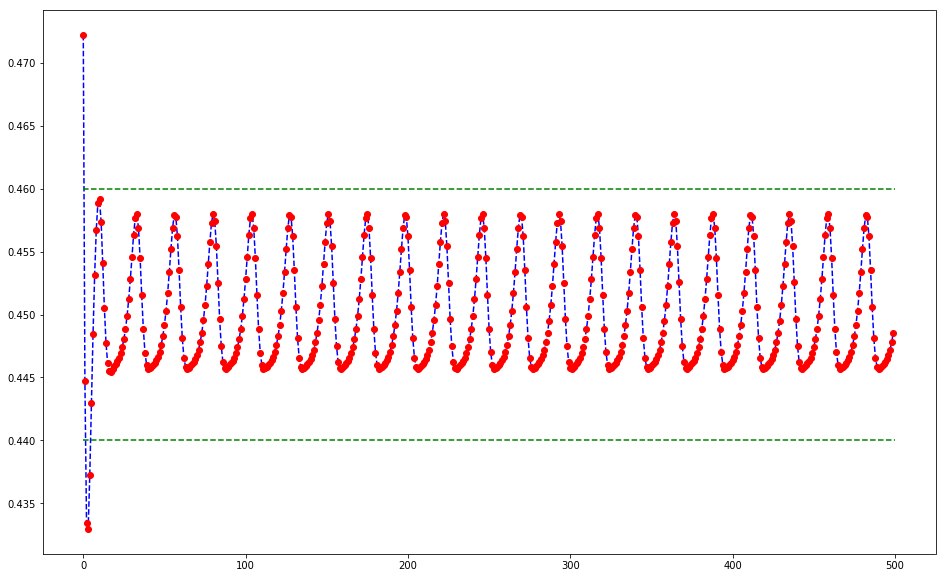

In [105]:
plt.figure(figsize=(16, 10))
plt.plot(P_list, '--b')
plt.plot(P_list, 'or')
plt.plot([0, len(P_list)], [0.44, 0.44], '--g')
plt.plot([0, len(P_list)], [0.46, 0.46], '--g')
plt.show()

### Gamma plot

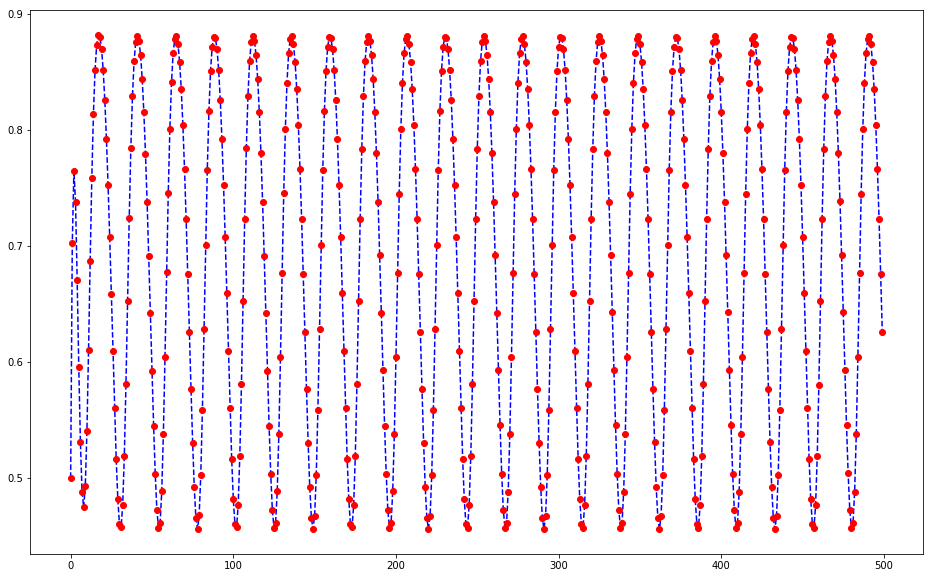

In [106]:
plt.figure(figsize=(16, 10))
plt.plot(gamma, '--b')
plt.plot(gamma, 'or')


plt.show()